In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.utils as utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml']

In [6]:
# # just specify up front so it doesnt take so long to load objects
# channels = sc.read_h5ad(
#     '/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s3_xenium.h5ad'
# ).var.index.to_list()
# len(channels)

In [7]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [8]:
xenium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': 0.,
        'codebook_size': 30,
        'decoder_dims': (256, 50, 50,)
    },
    'learner_kwargs': {
        'scale': .5,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cuda:0',
#         'channels': channels,
        'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 1000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 100,
#         'save_dir': chkpt_dir       
    },
}

In [9]:
# config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/{case}_codex/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [10]:
config

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s0_xenium.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s1_xenium.h5ad'}],
  'id': 's1',
  'position': 15},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s2_xenium.h5ad'}],
  'id': 's2',
  'position': 35},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 40},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s4_xenium.h5ad'}],
  'id': 's4',
  'position': 50},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s5_multiplex.o

In [11]:
# only keep the non-detached sections

In [12]:
for entry in config:
    if entry['data'][0]['dtype'] == 'multiplex':
        print(entry['id'], entry['position'])

s3 40
s5 60


In [13]:
xenium_config['sections'] = config
xenium_config['train_kwargs']['save_dir'] = chkpt_dir

In [14]:
mushroom = Mushroom.from_config(xenium_config)

INFO:root:using device: cuda:0
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 26 channels
INFO:root:2 sections detected: ['s3', 's5']
INFO:root:processing sections
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [15]:
# a1 = sc.read_h5ad('/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad')
# a1

In [16]:
# a2 = sc.read_h5ad('/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s3_xenium.h5ad')
# a2

In [17]:
next(iter(mushroom.learner.inference_ds.section_to_img.values())).shape

torch.Size([26, 5795, 5135])

In [18]:
mushroom.true_imgs.shape

torch.Size([2, 26, 5760, 5248])

In [19]:
mushroom.learner.channels

['Amylase (D)',
 'CD11b',
 'CD163',
 'CD20',
 'CD31',
 'CD3e',
 'CD4',
 'CD45',
 'CD68',
 'CD74 (D)',
 'CD8',
 'CFTR (D)',
 'CRP (D)',
 'DAPI',
 'E-cadherin',
 'HLA-DR',
 'INS (D)',
 'Ki67',
 'LAMC2 (D)',
 'MUC5AC (D)',
 'PGC (D)',
 'Podoplanin',
 'REG3A (D)',
 'SMA',
 'TFF1',
 'Vimentin']

In [20]:
b = next(iter(mushroom.learner.train_dl))

In [21]:
for k, v in b.items(): print(k, v.shape)

anchor_idx torch.Size([64])
pos_idx torch.Size([64])
anchor_tile torch.Size([64, 26, 256, 256])
pos_tile torch.Size([64, 26, 256, 256])


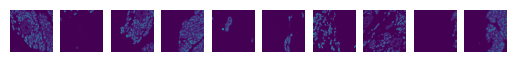

In [23]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['anchor_tile'][i, mushroom.learner.channels.index('E-cadherin')])
    ax.axis('off')

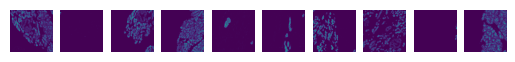

In [24]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['pos_tile'][i, mushroom.learner.channels.index('E-cadherin')])
    ax.axis('off')

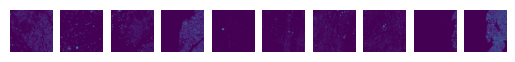

In [25]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['anchor_tile'][i, mushroom.learner.channels.index('CD45')])
    ax.axis('off')

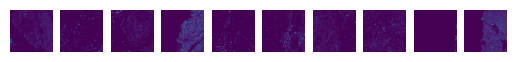

In [26]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['pos_tile'][i, mushroom.learner.channels.index('CD45')])
    ax.axis('off')

In [27]:
with torch.no_grad():
    device = mushroom.learner.device
    anchor_x, anchor_slide = b['anchor_tile'], b['anchor_idx']
    pos_x, pos_slide = b['pos_tile'], b['pos_idx']
    x = torch.concat((anchor_x, pos_x))
    slide = torch.concat((anchor_slide, pos_slide))
    x, slide = x.to(device), slide.to(device)

    losses, outputs = mushroom.learner.sae(x, slide)

In [28]:
for k, v in losses.items(): print(k, v)

overall_loss tensor(0.2714, device='cuda:0')
recon_loss tensor(0.2714, device='cuda:0')
kl_loss tensor(66.1231, device='cuda:0')
neigh_loss tensor(3.3959, device='cuda:0')


In [29]:
for k, v in outputs.items(): print(k, v.shape)

encoded_tokens_prequant torch.Size([128, 65, 256])
encoded_tokens torch.Size([128, 65, 256])
pred_pixel_values torch.Size([128, 64, 26])
clusters torch.Size([128, 64])


In [30]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(0.3103, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3103, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(66.1075, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.3925, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943_codex/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2414, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(109.0366, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9820, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4186, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(133.4507, device='cuda:0', grad_fn=<MeanBac

INFO:root:iteration 250: {'overall_loss': tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1614, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(327.1143, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.6527, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 260: {'overall_loss': tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1504, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(322.6439, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.6959, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 270: {'overall_loss': tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2267, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(334.6199, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.6986, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 280: {'overall_loss'

INFO:root:iteration 500: {'overall_loss': tensor(0.2128, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2128, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(381.9405, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.6139, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943_codex/outputs/chkpts/500iter.pt
INFO:root:iteration 510: {'overall_loss': tensor(0.2131, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2131, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(374.8635, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.6883, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 520: {'overall_loss': tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1682, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(375.5351, device='cuda:0', grad_fn=<

INFO:root:iteration 750: {'overall_loss': tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1289, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(399.9696, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.7715, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 760: {'overall_loss': tensor(0.2533, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2533, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(413.6085, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.7832, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 770: {'overall_loss': tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1551, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(402.0966, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8625, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 780: {'overall_loss'

INFO:root:iteration 1000: {'overall_loss': tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1038, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(470.8878, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8277, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943_codex/outputs/chkpts/1000iter.pt
INFO:root:saving final checkpoint to /data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943_codex/outputs/chkpts/final.pt
